<a href="https://colab.research.google.com/github/suozzi-matt/stock-tracker/blob/main/Cannabis_Stock_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
!pip install yahoofinancials
from yahoofinancials import YahooFinancials as yf
from scipy import stats
import matplotlib.pyplot as plt
import datetime

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=ae1ccb36a3e1de991585662173609514995c7ae32f7fd16aef663229d5905330
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [ ]:
# List of stock tickers
mso_tickers = ["CURLF", "CRLBF", "TCNNF", "GTBIF", "CCHWF", "HRVSF", "JUSHF", 'AYRWF', 'PLNHF']
yf_msos = yf(mso_tickers)
# consider start dates of 1/1/2019 & 3/12/2020
start_date1 = '2019-01-01'
start_date2 = '2019-07-01'
start_date_pandemic = '2020-03-12'
start_latest_ipo = '2021-01-05' #date of PLNHF IPO

In [ ]:
msos_price = wb.DataReader(mso_tickers, data_source='yahoo', start=start_date2)['Adj Close']
print(msos_price.head(10))
#change in stock price
msos_stock_change = pd.DataFrame(msos_price / msos_price.shift(1)-1)
print(msos_stock_change.head(10)) 
# mean return (annualized)
#std of returns 
cov_msos = msos_stock_change.cov()*250
corr_msos = msos_stock_change.corr()
# index closing price at 100
msos_index = pd.DataFrame(msos_price/msos_price.iloc[0])*100
print(msos_index.head(10))
#moving averages
short_rolling = msos_price.rolling(window=20).mean()
long_rolling = msos_price.rolling(window=100).mean()
# Transpose and join prices, short_rolling, long_rolling to chart by ticker

Symbols     CURLF   CRLBF   TCNNF   GTBIF  CCHWF  HRVSF  JUSHF  AYRWF  PLNHF
Date                                                                        
2019-07-01  7.140  10.680  11.400  11.480  6.600   6.36  2.135    NaN   2.03
2019-07-02  7.083  10.287  11.420  11.300  5.950   6.13  2.009    NaN   2.02
2019-07-03  6.926  10.100  11.400  11.025  5.094   6.09  1.992    NaN   2.07
2019-07-05  7.010  10.009  11.233  10.700  4.910   6.02  1.980    NaN   2.05
2019-07-08  7.000  10.110  10.967  10.332  4.543   5.95  1.997    NaN   1.97
2019-07-09  6.838   9.647  10.506  10.140  4.457   6.13  1.977    NaN   1.92
2019-07-10  6.860   9.792  10.230  10.192  4.490   6.25  2.070    NaN   1.85
2019-07-11  6.537   9.670   9.850   9.932  3.788   6.12  1.835    NaN   1.90
2019-07-12  6.410   9.590  10.400   9.791  3.750   5.87  2.100    NaN   1.80
2019-07-15  6.510   9.417  10.400   9.588  3.670   5.69  2.000    NaN   1.88
Symbols        CURLF     CRLBF     TCNNF  ...     JUSHF  AYRWF     PLNHF
Dat

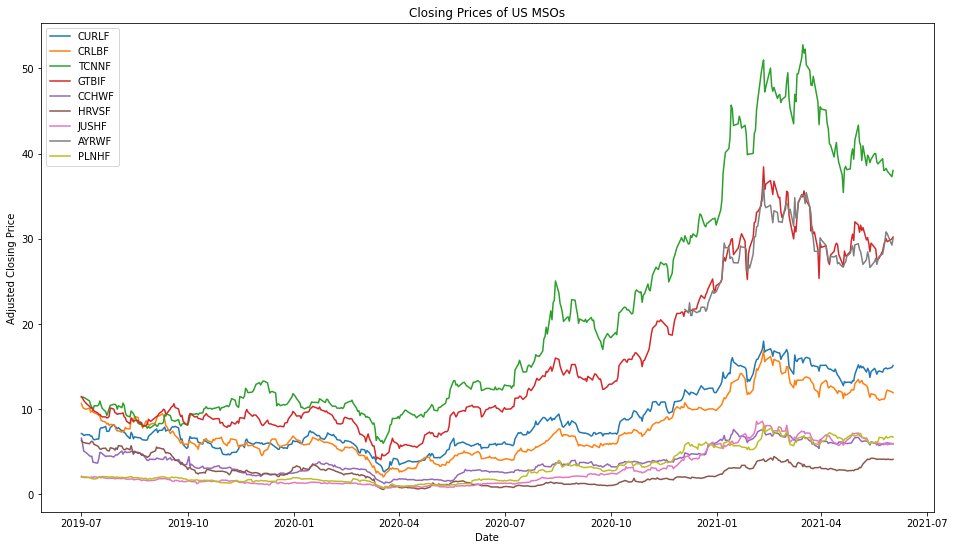

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(msos_price)
#ax.plot(short_rolling, label='20 day rolling')
#ax.plot(long_rolling, label='100 day rolling')
ax.set_xlabel('Date')
ax.set_ylabel("Adjusted Closing Price")
ax.set_title('Closing Prices of US MSOs')
ax.legend(mso_tickers)

plt.show()

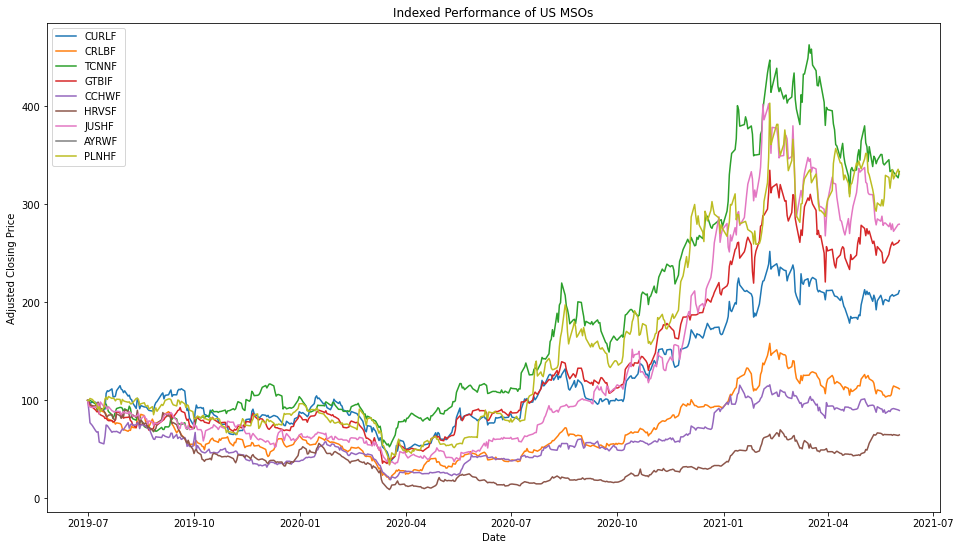

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

#msos_index.plot(title="Indexed Performance of US MSOs")

ax.plot(msos_index)
#plt.axvline(x='2020-03-12', c='r')
#ax.plot(short_rolling, label='20 day rolling')
#ax.plot(long_rolling, label='100 day rolling')
ax.set_xlabel('Date')
ax.set_ylabel("Adjusted Closing Price")
ax.set_title('Indexed Performance of US MSOs')
ax.legend(mso_tickers)

plt.show()

In [ ]:
# https://ycharts.com/companies/CRLBF/market_cap

CURLF    10740017152
CRLBF     2942467584
TCNNF     6084040704
GTBIF     7526993920
CCHWF     1750461696
HRVSF     1293747840
JUSHF      822426304
Name: marketCap, dtype: int64

In [ ]:
# Market capitalization 
msos_cap = wb.get_quote_yahoo(mso_tickers)['marketCap']

#Financial Information - takes approx 2 minutes to run
msos_financials = yf_msos.get_financial_stmts('quarterly',['income','balance'])

# Income Statement
mso_inc_statement = msos_financials['incomeStatementHistoryQuarterly']

# Balance Sheet
mso_bal_sheet = msos_financials['balanceSheetHistoryQuarterly']
#crlbf_bal_sheet = mso_bal_sheet['CRLBF']


,CURLF,CRLBF,TCNNF,GTBIF,CCHWF,HRVSF,JUSHF,AYRWF,PLNHF
2021-03-31,260320000.0,174487000.0,193823000.0,194430584.0,86095000.0,88826000.0,NaN,58398323.0,23816208.0
2020-12-31,230252000.0,157676000.0,168437293.0,177226522.0,76064000.0,69913000.0,NaN,47764775.0,20139944.0
2020-09-30,182408000.0,148987000.0,136274321.0,157103841.0,48703000.0,61643000.0,24913000.0,45486365.0,22797338.0
2020-06-30,117480000.0,91909000.0,120764879.0,119639924.0,28413000.0,55669000.0,14932000.0,28310633.0,10760996.0
2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,8632574.0,NaN,NaN
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,6034039.0,NaN,NaN


In [ ]:
# Extract revenues only
mso_revenues = {} # {MSO: {Date: Revenue.value, Date: Revenue.value,...}, MSO: {...},...}

for mso in mso_inc_statement:
  statements = {}
  stmts = mso_inc_statement[mso]
  for stmt in stmts:
    for date, accounts in stmt.items():
      for account, value in accounts.items(): 
        if account == 'totalRevenue':
          statements[date] = value
  mso_revenues[mso] = statements

mso_quarterly_rev = pd.DataFrame(mso_revenues)
mso_quarterly_rev

,CURLF,CRLBF,TCNNF,GTBIF,CCHWF,HRVSF,JUSHF,AYRWF,PLNHF
2021-03-31,260320000.0,174487000.0,193823000.0,194430584.0,86095000.0,88826000.0,NaN,58398323.0,23816208.0
2020-12-31,230252000.0,157676000.0,168437293.0,177226522.0,76064000.0,69913000.0,NaN,47764775.0,20139944.0
2020-09-30,182408000.0,148987000.0,136274321.0,157103841.0,48703000.0,61643000.0,24913000.0,45486365.0,22797338.0
2020-06-30,117480000.0,91909000.0,120764879.0,119639924.0,28413000.0,55669000.0,14932000.0,28310633.0,10760996.0
2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,8632574.0,NaN,NaN
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,6034039.0,NaN,NaN


               CURLF     CRLBF     TCNNF  ...     JUSHF     AYRWF     PLNHF
2021-03-31  0.130587  0.106617  0.150713  ...       NaN  0.222623  0.182536
2020-12-31  0.262291  0.058321  0.236016  ...       NaN  0.050090 -0.116566
2020-09-30  0.552673  0.621027  0.128427  ...  0.668430  0.606688  1.118516
2020-06-30       NaN       NaN       NaN  ...  0.729727       NaN       NaN
2020-03-31       NaN       NaN       NaN  ...  0.430646       NaN       NaN
2019-12-31       NaN       NaN       NaN  ...       NaN       NaN       NaN

[6 rows x 9 columns]


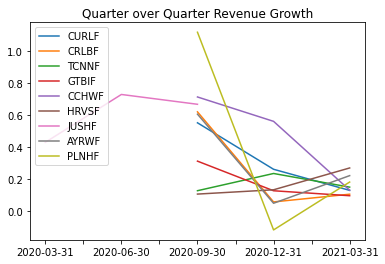

In [ ]:
mso_rev_growth = pd.DataFrame(mso_quarterly_rev / mso_quarterly_rev.shift(-1)-1)
print(mso_rev_growth)

ax = mso_rev_growth.plot(title='Quarter over Quarter Revenue Growth')
ax.invert_xaxis()
plt.legend(loc='upper left')
plt.show()

In [ ]:
# extract only most recent revenue
mso_rev = {}
for mso in mso_inc_statement: # loop through each MSO
  stmt = mso_inc_statement[mso][0] # extract the most recent statement
  for date, account in stmt.items(): # key, value pairs in most recent statement
    revenue = account['totalRevenue'] # value for key='totalRevenue'
    mso_rev[mso] = revenue # add most recent revenue to dictionary with key=mso

print("Last Quarter Revenue: {}".format(mso_rev))

# calculate LQA revenue
mso_lqa_rev = mso_rev
for mso in mso_rev:
  mso_lqa_rev[mso] *= 4

print("LQA Revenue: {}".format(mso_lqa_rev))

mso_avg_growth = mso_rev_growth.mean()
print(mso_avg_growth)

# estimate NTM revenue based on assumptions and guidance (if provided)
mso_ntm_growth = mso_avg_growth
# manual adjustments to NTM growth assumptions
mso_ntm_growth['CCHWF'] = 0.65

mso_ntm_rev = mso_rev
for mso in mso_ntm_rev:
  mso_ntm_rev[mso] = mso_lqa_rev[mso] * (1 + mso_ntm_growth[mso]) # based on NTM Growth assumptions above (set equal to avg growth)

print("Estimated NTM Revenue: {}".format(mso_ntm_rev))

Last Quarter Revenue: {'CURLF': 260320000, 'CRLBF': 174487000, 'TCNNF': 193823000, 'GTBIF': 194430584, 'CCHWF': 86095000, 'HRVSF': 88826000, 'JUSHF': 24913000, 'AYRWF': 58398323, 'PLNHF': 23816208}
LQA Revenue: {'CURLF': 1041280000, 'CRLBF': 697948000, 'TCNNF': 775292000, 'GTBIF': 777722336, 'CCHWF': 344380000, 'HRVSF': 355304000, 'JUSHF': 99652000, 'AYRWF': 233593292, 'PLNHF': 95264832}
CURLF    0.315184
CRLBF    0.261988
TCNNF    0.171719
GTBIF    0.179433
CCHWF    0.469259
HRVSF    0.170665
JUSHF    0.609601
AYRWF    0.293134
PLNHF    0.394829
dtype: float64
Estimated NTM Revenue: {'CURLF': 1369474545.4091132, 'CRLBF': 880802282.6812524, 'TCNNF': 908424171.0314741, 'GTBIF': 917271130.2955214, 'CCHWF': 568227000.0, 'HRVSF': 415941885.85228246, 'JUSHF': 160399981.5174656, 'AYRWF': 302067393.23051393, 'PLNHF': 132878105.60772203}


In [ ]:
mso_annual_revenue = pd.DataFrame(mso_quarterly_rev).sum()
# add column name for LTM revenue
# add LQA Revenue, NTM Growth, NTM Revenue to DataFrame
# mso_annual_revenue['LQA Revenue'] = mso_quarterly_rev.iloc[0]*4
mso_annual_revenue

CURLF    790460000.0
CRLBF    573059000.0
TCNNF    619299493.0
GTBIF    648400871.0
CCHWF    239275000.0
HRVSF    276051000.0
JUSHF     54511613.0
AYRWF    179960096.0
PLNHF     77514486.0
dtype: float64

In [ ]:
# Gross profit (margin)

# Adj. EBITDA (margin)

In [ ]:
msos_data = pd.DataFrame(msos_cap)
msos_data["LTM Revenue"] = mso_annual_revenue
#msos_data["LQA Revenue"] = mso_lqa_rev.values() # why does this equal NTM?
msos_data["NTM Revenue"] = mso_ntm_rev.values()
msos_data["NTM Growth"] = mso_ntm_growth
msos_data

,marketCap,LTM Revenue,NTM Revenue,NTM Growth
CURLF,10634723328,790460000.0,1.369475e+09,0.315184
CRLBF,2891724544,573059000.0,8.808023e+08,0.261988
TCNNF,6766560768,619299493.0,9.084242e+08,0.171719
GTBIF,6581459456,648400871.0,9.172711e+08,0.179433
CCHWF,1774265472,239275000.0,5.682270e+08,0.650000
HRVSF,1684367232,276051000.0,4.159419e+08,0.170665
JUSHF,671560128,54511613.0,1.604000e+08,0.609601
AYRWF,1715607040,179960096.0,3.020674e+08,0.293134
PLNHF,1308422656,77514486.0,1.328781e+08,0.394829


In [ ]:
# extract cash and debt
mso_cash = {}
for mso in mso_bal_sheet:
  statements = {}
  stmts = mso_bal_sheet[mso]
  for stmt in stmts:
    for date, accounts in stmt.items():
      for account, value in accounts.items(): 
        if account == 'cash':
          statements[date] = value
  mso_cash[mso] = statements

mso_debt = {}
for mso in mso_bal_sheet:
  statements = {}
  total = 0
  stmts = mso_bal_sheet[mso]
  for stmt in stmts:
    for date, accounts in stmt.items():
      for account, value in accounts.items(): 
        if account == 'longTermDebt' or account == 'shortLongTermDebt':
          total += value
        statements[date] = total
  mso_debt[mso] = statements

# manual adjustments for debt accounts (ex. CRLBF total liabilities includes other debt)
mso_debt['CRLBF']['2020-09-30'] = 290534000

print(pd.DataFrame(mso_cash))
print(pd.DataFrame(mso_debt))

mso_net_debt = pd.DataFrame(mso_debt)-pd.DataFrame(mso_cash)
print(mso_net_debt)

                  CURLF        CRLBF  ...        AYRWF        PLNHF
2021-03-31  314591000.0  255503000.0  ...  195649339.0  141126157.0
2020-12-31   73542000.0  136339000.0  ...  127238165.0   79000850.0
2020-09-30   84586000.0   57689000.0  ...   23180198.0   56760860.0
2020-06-30  122763000.0   70994000.0  ...   15986515.0   22724824.0
2020-03-31          NaN          NaN  ...          NaN          NaN
2019-12-31          NaN          NaN  ...          NaN          NaN

[6 rows x 9 columns]
                   CURLF        CRLBF  ...        AYRWF      PLNHF
2021-03-31  3.395130e+08  258370000.0  ...  194725450.0   884000.0
2020-12-31  6.310140e+08  427845000.0  ...  360610994.0  1768000.0
2020-09-30  9.109990e+08  290534000.0  ...  401323918.0  2652000.0
2020-06-30  1.190848e+09  530795000.0  ...  443410384.0  3536000.0
2020-03-31           NaN          NaN  ...          NaN        NaN
2019-12-31           NaN          NaN  ...          NaN        NaN

[6 rows x 9 columns]
           

In [ ]:
# add most recent net debt amount
if mso_net_debt.iloc[0].any(skipna=False):
  msos_data['Net Debt'] = mso_net_debt.iloc[1]
else: 
  msos_data['Net Debt'] = mso_net_debt.iloc[0]

# Calculate Enterprise Value and EV multiple based off of NTM Revenue
msos_data["Enterprise Value"] = msos_data['marketCap'] + msos_data['Net Debt']
msos_data["EV to NTM Rev"] = msos_data["Enterprise Value"]/msos_data['NTM Revenue']
msos_data["Capitalization"] = msos_data["Net Debt"]/msos_data["Enterprise Value"]
msos_data

,marketCap,LTM Revenue,NTM Revenue,NTM Growth,Net Debt,Enterprise Value,EV to NTM Rev,Capitalization
CURLF,10634723328,790460000.0,1.369475e+09,0.315184,557472000.0,1.119220e+10,8.172620,0.049809
CRLBF,2891724544,573059000.0,8.808023e+08,0.261988,291506000.0,3.183231e+09,3.614013,0.091576
TCNNF,6766560768,619299493.0,9.084242e+08,0.171719,292858000.0,7.059419e+09,7.771060,0.041485
GTBIF,6581459456,648400871.0,9.172711e+08,0.179433,115369131.0,6.696829e+09,7.300817,0.017227
CCHWF,1774265472,239275000.0,5.682270e+08,0.650000,111030000.0,1.885295e+09,3.317856,0.058893
HRVSF,1684367232,276051000.0,4.159419e+08,0.170665,456680000.0,2.141047e+09,5.147467,0.213297
JUSHF,671560128,54511613.0,1.604000e+08,0.609601,NaN,NaN,NaN,NaN
AYRWF,1715607040,179960096.0,3.020674e+08,0.293134,233372829.0,1.948980e+09,6.452136,0.119741
PLNHF,1308422656,77514486.0,1.328781e+08,0.394829,-77232850.0,1.231190e+09,9.265558,-0.062730


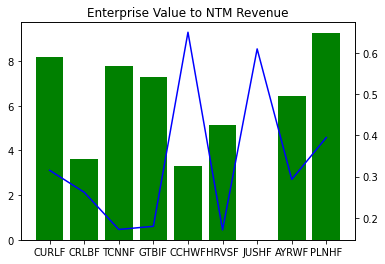

In [ ]:
# plot
fig, ax1 = plt.subplots()
ax1.bar(mso_tickers,msos_data["EV to NTM Rev"], color = 'green')
ax2 = msos_data['NTM Growth'].plot(secondary_y=True, color = 'blue')
plt.title("Enterprise Value to NTM Revenue")
plt.show()

Blue line is NTM Growth projections.

Higher multiples would be expected to be associated with higher NTM growth,  size (revenue and market cap less debt), and EBITDA margins.